In [13]:
import pandas as pd 

loc = './tables/NoPE_distance.csv'

df = pd.read_csv(loc, index_col='train/global_step')
df.rename(columns={col: col.replace('Group: null - ', '') for col in df.columns}, inplace=True)

step = 10000

df.loc[step]


_step                                4565.500000
_step__MIN                           4532.000000
_step__MAX                           4599.000000
eval/12-add-reverse_distance            1.000000
eval/12-add-reverse_distance__MIN       1.000000
eval/12-add-reverse_distance__MAX       1.000000
eval/16-add-reverse_distance            1.000000
eval/16-add-reverse_distance__MIN       1.000000
eval/16-add-reverse_distance__MAX       1.000000
eval/20-add-reverse_distance            0.999822
eval/20-add-reverse_distance__MIN       0.999379
eval/20-add-reverse_distance__MAX       1.000000
eval/24-add-reverse_distance            0.986929
eval/24-add-reverse_distance__MIN       0.975173
eval/24-add-reverse_distance__MAX       0.998761
eval/28-add-reverse_distance            0.906429
eval/28-add-reverse_distance__MIN       0.879492
eval/28-add-reverse_distance__MAX       0.929395
eval/32-add-reverse_distance            0.791748
eval/32-add-reverse_distance__MIN       0.772260
eval/32-add-reverse_

In [1]:
import os
import pickle
import pandas as pd 
import wandb
from tqdm.notebook import tqdm

api = wandb.Api()

filters = {
    "NoPE": {
        "State": "finished",
        "config.do_train": True,
        "config.rope_theta": "Infinity",
        "config.padding_side": "random"
    },
    "RoPE": {
        "State": "finished",
        "config.do_train": True,
        "config.rope_theta": 1e5,
        "config.learning_rate": 5e-4,
        "config.hidden_size": 768,
        "display_name": {"$regex": "base-llama-768-12-12-1024-rope-reverse-no-carry_reverse-carry-only_reverse-digits-1_33_1_33_1_17*"}
    },
    "A -> C": {
        "State": "finished",
        "config.do_train": True,
        "config.rope_theta": 1e5,
        "config.learning_rate": 5e-4,
        "config.hidden_size": 768,
        "display_name": {"$regex": "ablation-llama-768-12-12-1024-rope-reverse-carry-only_reverse-digits-1_33_1_17*"},
        "duration": {"$gte": 3600},
        "config.lr_scheduler_type": "warmup_stable_decay"
    },
    "B -> C": {
        "State": "finished",
        "config.do_train": True,
        "config.rope_theta": 1e5,
        "config.learning_rate": 5e-4,
        "config.hidden_size": 768,
        "display_name": {"$regex": "ablation-llama-768-12-12-1024-rope-reverse-no-carry_reverse-digits-1_33_1_17*"},
        "duration": {"$gte": 3600},
        "config.lr_scheduler_type": "warmup_stable_decay"
    },
    "C -> A, B": {
        "State": "finished",
        "config.do_train": True,
        "config.rope_theta": 1e5,
        "config.learning_rate": 5e-4,
        "config.hidden_size": 768,
        "display_name": {"$regex": "base-llama-768-12-12-1024-rope-reverse-no-carry_reverse-carry-only_reverse-digits-1_17_1_17_1_33"},
        "duration": {"$gte": 3600},
        "config.lr_scheduler_type": "warmup_stable_decay"
    },
    "Sweep_32_16": {
        "State": "finished",
        "config.do_train": True,
        "config.rope_theta": 1e5,
        "config.learning_rate": 1e-3,
        "config.hidden_size": 384,
        "display_name": {"$regex": "sweep-llama-384-6-6-1024-rope-reverse-no-carry_reverse-carry-only_reverse-digits-1_33_1_33_1_17"},
        "duration": {"$gte": 3600},
        "config.lr_scheduler_type": "warmup_stable_decay",
        "config_use_train_attention_mask": {"$in": [True, None]}
    }
}

run_groups = {}

for group_name, filter in filters.items():
    if os.path.exists(f'out/{group_name}.pkl'):
        run_groups[group_name] = pickle.load(open(f'out/{group_name}.pkl', 'rb'))
        continue
    
    # Project is specified by <entity/project-name>
    runs = api.runs("jackcai1206/LG-inherit", filters=filters[group_name])
    print(f"Found {len(runs)} runs for {group_name}")

    hist_list, config_list, name_list = [], [], []
    for run in runs: 
        print(run.name)
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        # summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config = {k: v for k,v in run.config.items()
            if not k.startswith('_')}
        config_list.append(config)

        # .name is the human-readable name of the run.
        name_list.append(run.name)

        lengths = range(*config['n_digits_eval'])
        keys = []
        for j, (op, format, n_digits_train) in enumerate(zip(config['op_eval'], config['format_eval'], config['n_digits_train'])):
            for l in lengths:
                keys.append(f'eval/{l}-{op}-{format}_accuracy')
                keys.append(f'eval/{l}-{op}-{format}_distance')
        hist = []
        for key in keys:
            h = run.history(samples=config['max_steps'], x_axis='train/global_step', keys=[key])
            # h.rename(columns={key: key + config['seed']}, inplace=True)
            h.set_index('train/global_step', inplace=True)
            h = h.groupby('train/global_step').mean()
            hist.append(h)
        hist_join = hist[0].join(hist[1:])
        hist_list.append(hist_join)

    hist_list = pd.concat(hist_list)

    run_groups[group_name] = (hist_list, config_list, name_list)

    pickle.dump(run_groups[group_name], open(f'out/{group_name}.pkl', 'wb'))
    # runs_df.to_csv(f"{group_name}.csv")

Found 4 runs for C -> A, B
base-llama-768-12-12-1024-rope-reverse-no-carry_reverse-carry-only_reverse-digits-1_17_1_17_1_33-seed-42
base-llama-768-12-12-1024-rope-reverse-no-carry_reverse-carry-only_reverse-digits-1_17_1_17_1_33-seed-43
base-llama-768-12-12-1024-rope-reverse-no-carry_reverse-carry-only_reverse-digits-1_17_1_17_1_33-seed-44
base-llama-768-12-12-1024-rope-reverse-no-carry_reverse-carry-only_reverse-digits-1_17_1_17_1_33-seed-45


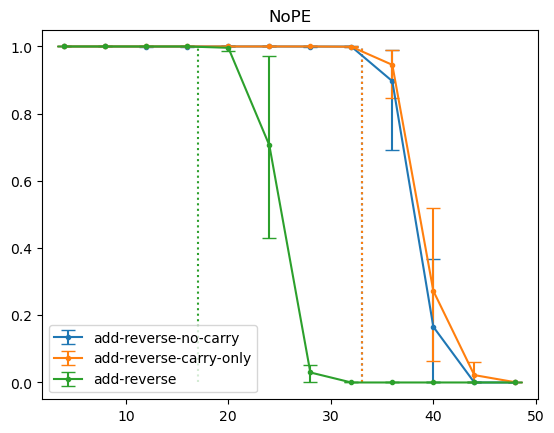

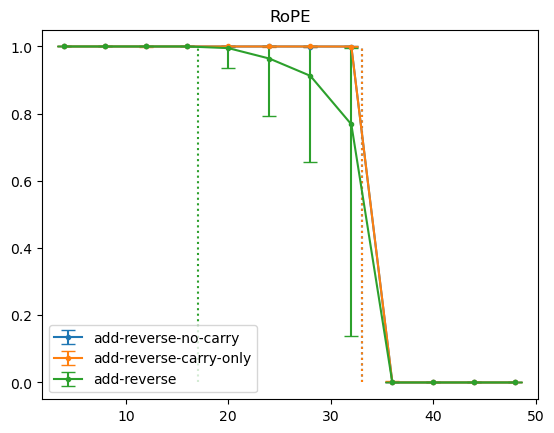

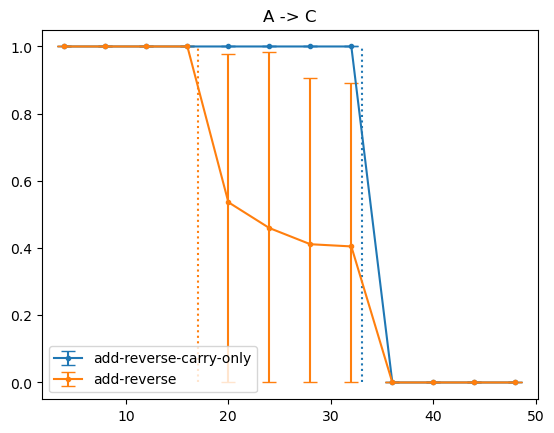

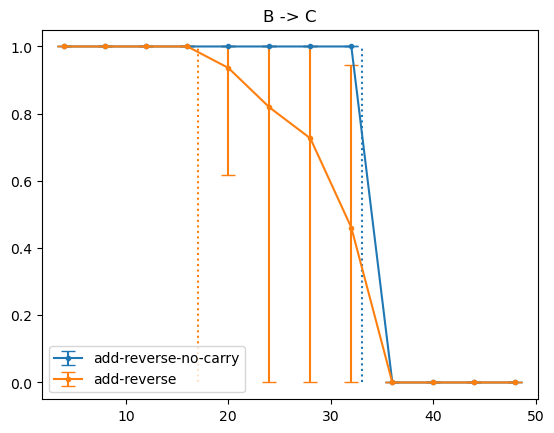

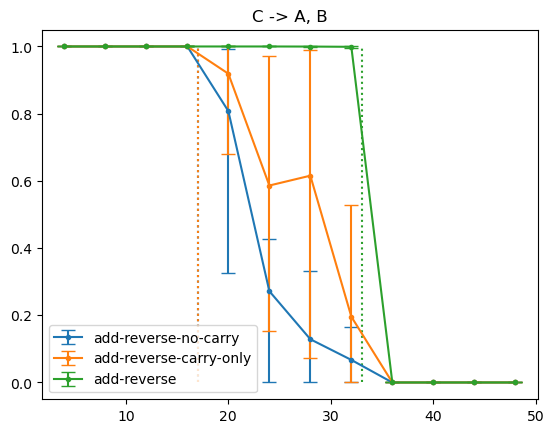

In [2]:
import matplotlib.pyplot as plt
from seaborn import color_palette

for group_name, (history, config, name) in run_groups.items():
    config = config[0]
    lengths = list(range(*config['n_digits_eval']))
    df = history.loc[10000]
    fig = plt.figure()
    for j, (op, format, n_digits_train) in enumerate(zip(config['op_eval'], config['format_eval'], config['n_digits_train'])):
        for metric in ['accuracy', 'distance'][:1]:
            keys = []
            for l in lengths:
                keys.append(f'eval/{l}-{op}-{format}_{metric}')
            y = df[keys].groupby(level=0)
            y_mean = y.mean().values[0]
            y_min = y.min().values[0]
            y_max = y.max().values[0]
            y_std = y.std().values[0]
            plt.errorbar(
                lengths, y_mean,
                label=f'{op}-{format}' if metric == 'accuracy' else None,
                linestyle='-' if metric == 'accuracy' else '--',
                color = color_palette()[j],
                yerr=[y_mean - y_min, y_max - y_mean],
                # yerr=y_std,
                lolims=0,
                uplims=0,
                marker='.',
                capsize=5
            )
            plt.vlines(n_digits_train[1], 0, 1, color=color_palette()[j], linestyle=':')
            plt.legend()
            plt.title(f'{group_name}')